<a href="https://colab.research.google.com/github/AmoghAN01/ML-DL-projects/blob/main/GAN_for_DigitGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digit Generation [4] using GAN

##Overview
This project implements a Generative Adversarial Network (GAN) designed to generate realistic images of handwritten digit 4 using the MNIST dataset. The project demonstrates advanced deep learning techniques in image generation and neural network design.
##The Dataset
Source: MNIST Handwritten Digit Dataset
Focus: Exclusively trained on digit 4 images
Preprocessing:
Normalized pixel values to [0, 1]
Filtered and isolated digit 4 samples
##Methodology
Model Architecture

Generator:
Input: Random noise vector
Layers: Dense, BatchNormalization, Conv2DTranspose
Output: 28x28 grayscale image

Discriminator:
Convolutional neural network
Binary classification of real vs. generated images

Training Strategy

Epochs: 100

Optimizer: Adam

Loss Function: Binary Cross-Entropy

##Results
Loss Progression: Demonstrated consistent reduction in generator loss
Final Loss: Converged to approximately 1.2
Generated 100 Images: Realistic representations of digit 4

##Conclusion
The Generative Adversarial Network developed in this project successfully learned to generate synthetic images of the digit 4 with remarkable precision.
Key observations from the project include:
Consistent reduction in generator loss, indicating improved image generation capabilities
Stable training process with minimal mode collapse
Generation of images that closely resemble the original MNIST digit 4 samples
While the current implementation provides promising results, there remains significant potential for future enhancement through architectural modifications, extended training, and advanced GAN techniques.

In [9]:
!pip install tensorflow opencv-python-headless matplotlib plotly


In [11]:
import numpy as np
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [12]:
# loading th data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Filter out only 4
x_train = x_train[y_train == 4]
y_train = y_train[y_train == 4]


BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')


x_train = x_train / 255
x_test = x_test / 255


x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Input data shape: (5800, 28, 28)
Number of labels: 5800


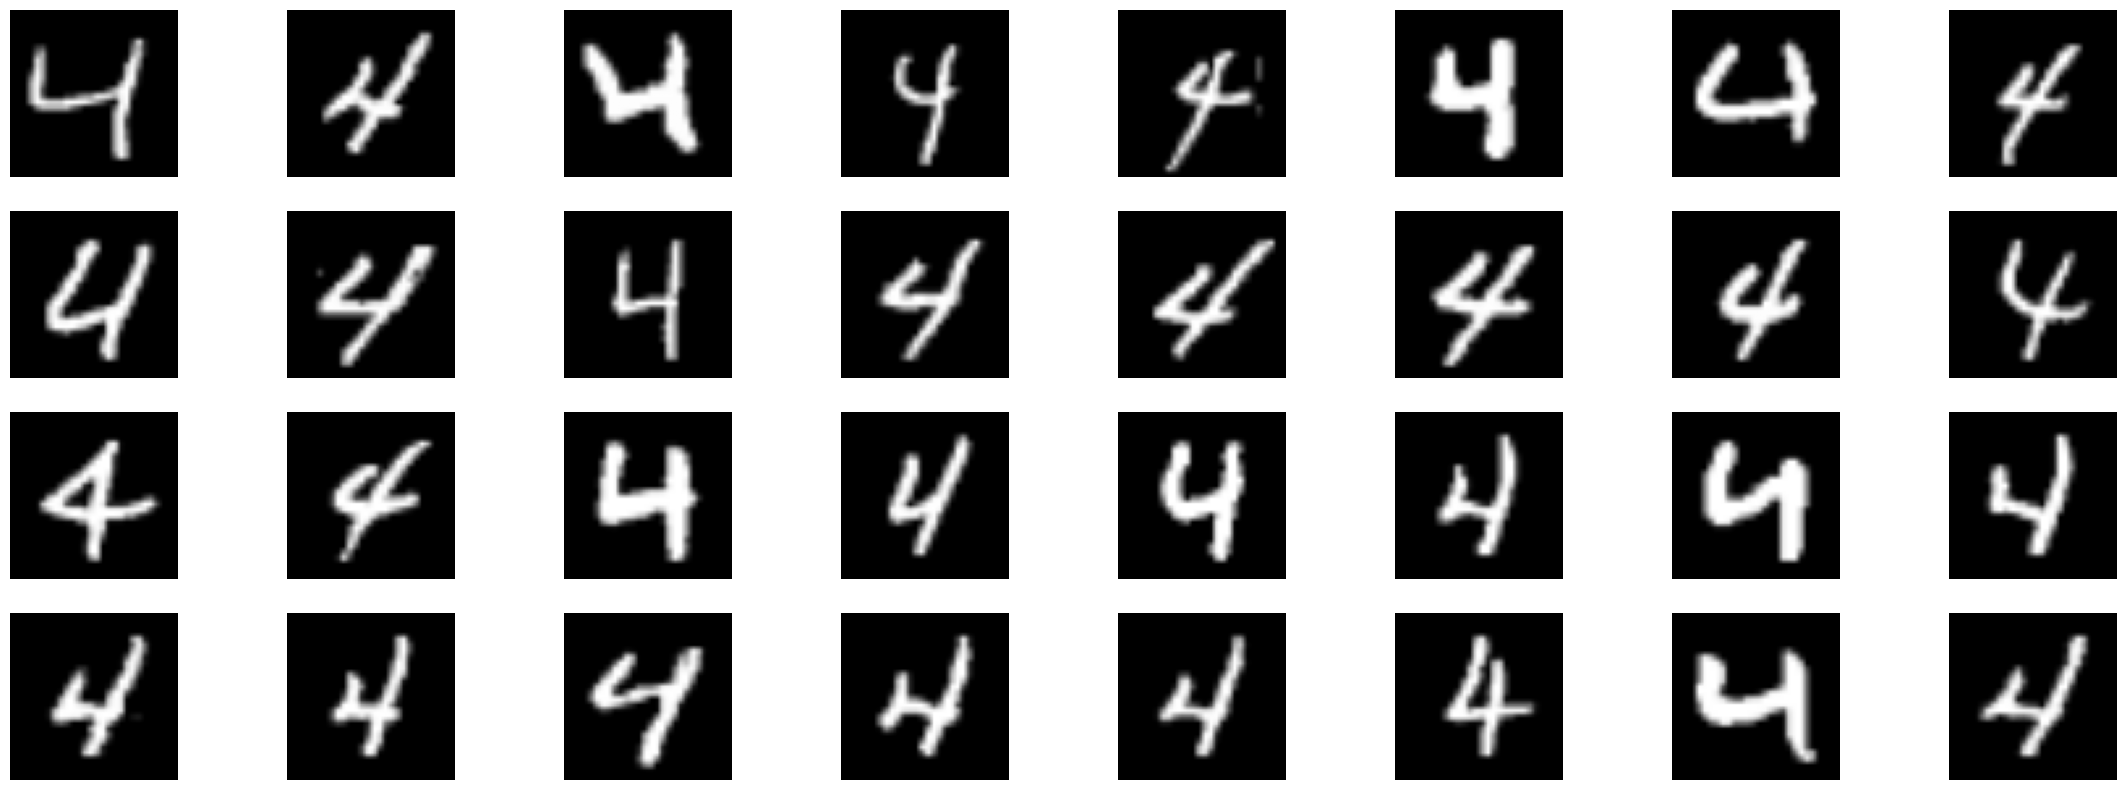

In [13]:
cnt_imgs = 32
counter = 0
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')
    counter += 1
    if counter == cnt_imgs:
        break
plt.show()


In [14]:
#The loss function
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)


In [15]:

hidden_dim = 2


generator = Sequential(name='generator')
generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))
generator.summary()


discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()


generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,114,369 (4.25 MB)

 Trainable params: 1,088,897 (4.15 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 608,129 (2.32 MB)

 Trainable params: 608,129 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, hidden_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs):

    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)

    for epoch in range(1, epochs + 1):
        print(f'{epoch}/{epochs}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0):
                print('=', end='')
            n += 1
        print('>', end = ' ')

        history += [gen_loss_epoch / n]
        print(': loss = ' + str(history[-1]))
        print(f'The time of the epoch {epoch} is: {time.time() - start} second')
    return history


In [19]:
EPOCHS = 100
gen_history = train(train_dataset, EPOCHS)


1/100: ============> : loss = tf.Tensor(2.7337546, shape=(), dtype=float32)
The time of the epoch 1 is: 0.49140453338623047 second
2/100: ============> : loss = tf.Tensor(2.4449427, shape=(), dtype=float32)
The time of the epoch 2 is: 0.4859762191772461 second
3/100: ============> : loss = tf.Tensor(2.2545335, shape=(), dtype=float32)
The time of the epoch 3 is: 0.4911530017852783 second
4/100: ============> : loss = tf.Tensor(2.0410388, shape=(), dtype=float32)
The time of the epoch 4 is: 0.4811077117919922 second
5/100: ============> : loss = tf.Tensor(2.457435, shape=(), dtype=float32)
The time of the epoch 5 is: 0.483705997467041 second
6/100: ============> : loss = tf.Tensor(2.2165585, shape=(), dtype=float32)
The time of the epoch 6 is: 0.4868786334991455 second
7/100: ============> : loss = tf.Tensor(1.8976151, shape=(), dtype=float32)
The time of the epoch 7 is: 0.49469828605651855 second
8/100: ============> : loss = tf.Tensor(1.8796315, shape=(), dtype=float32)
The time of th

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

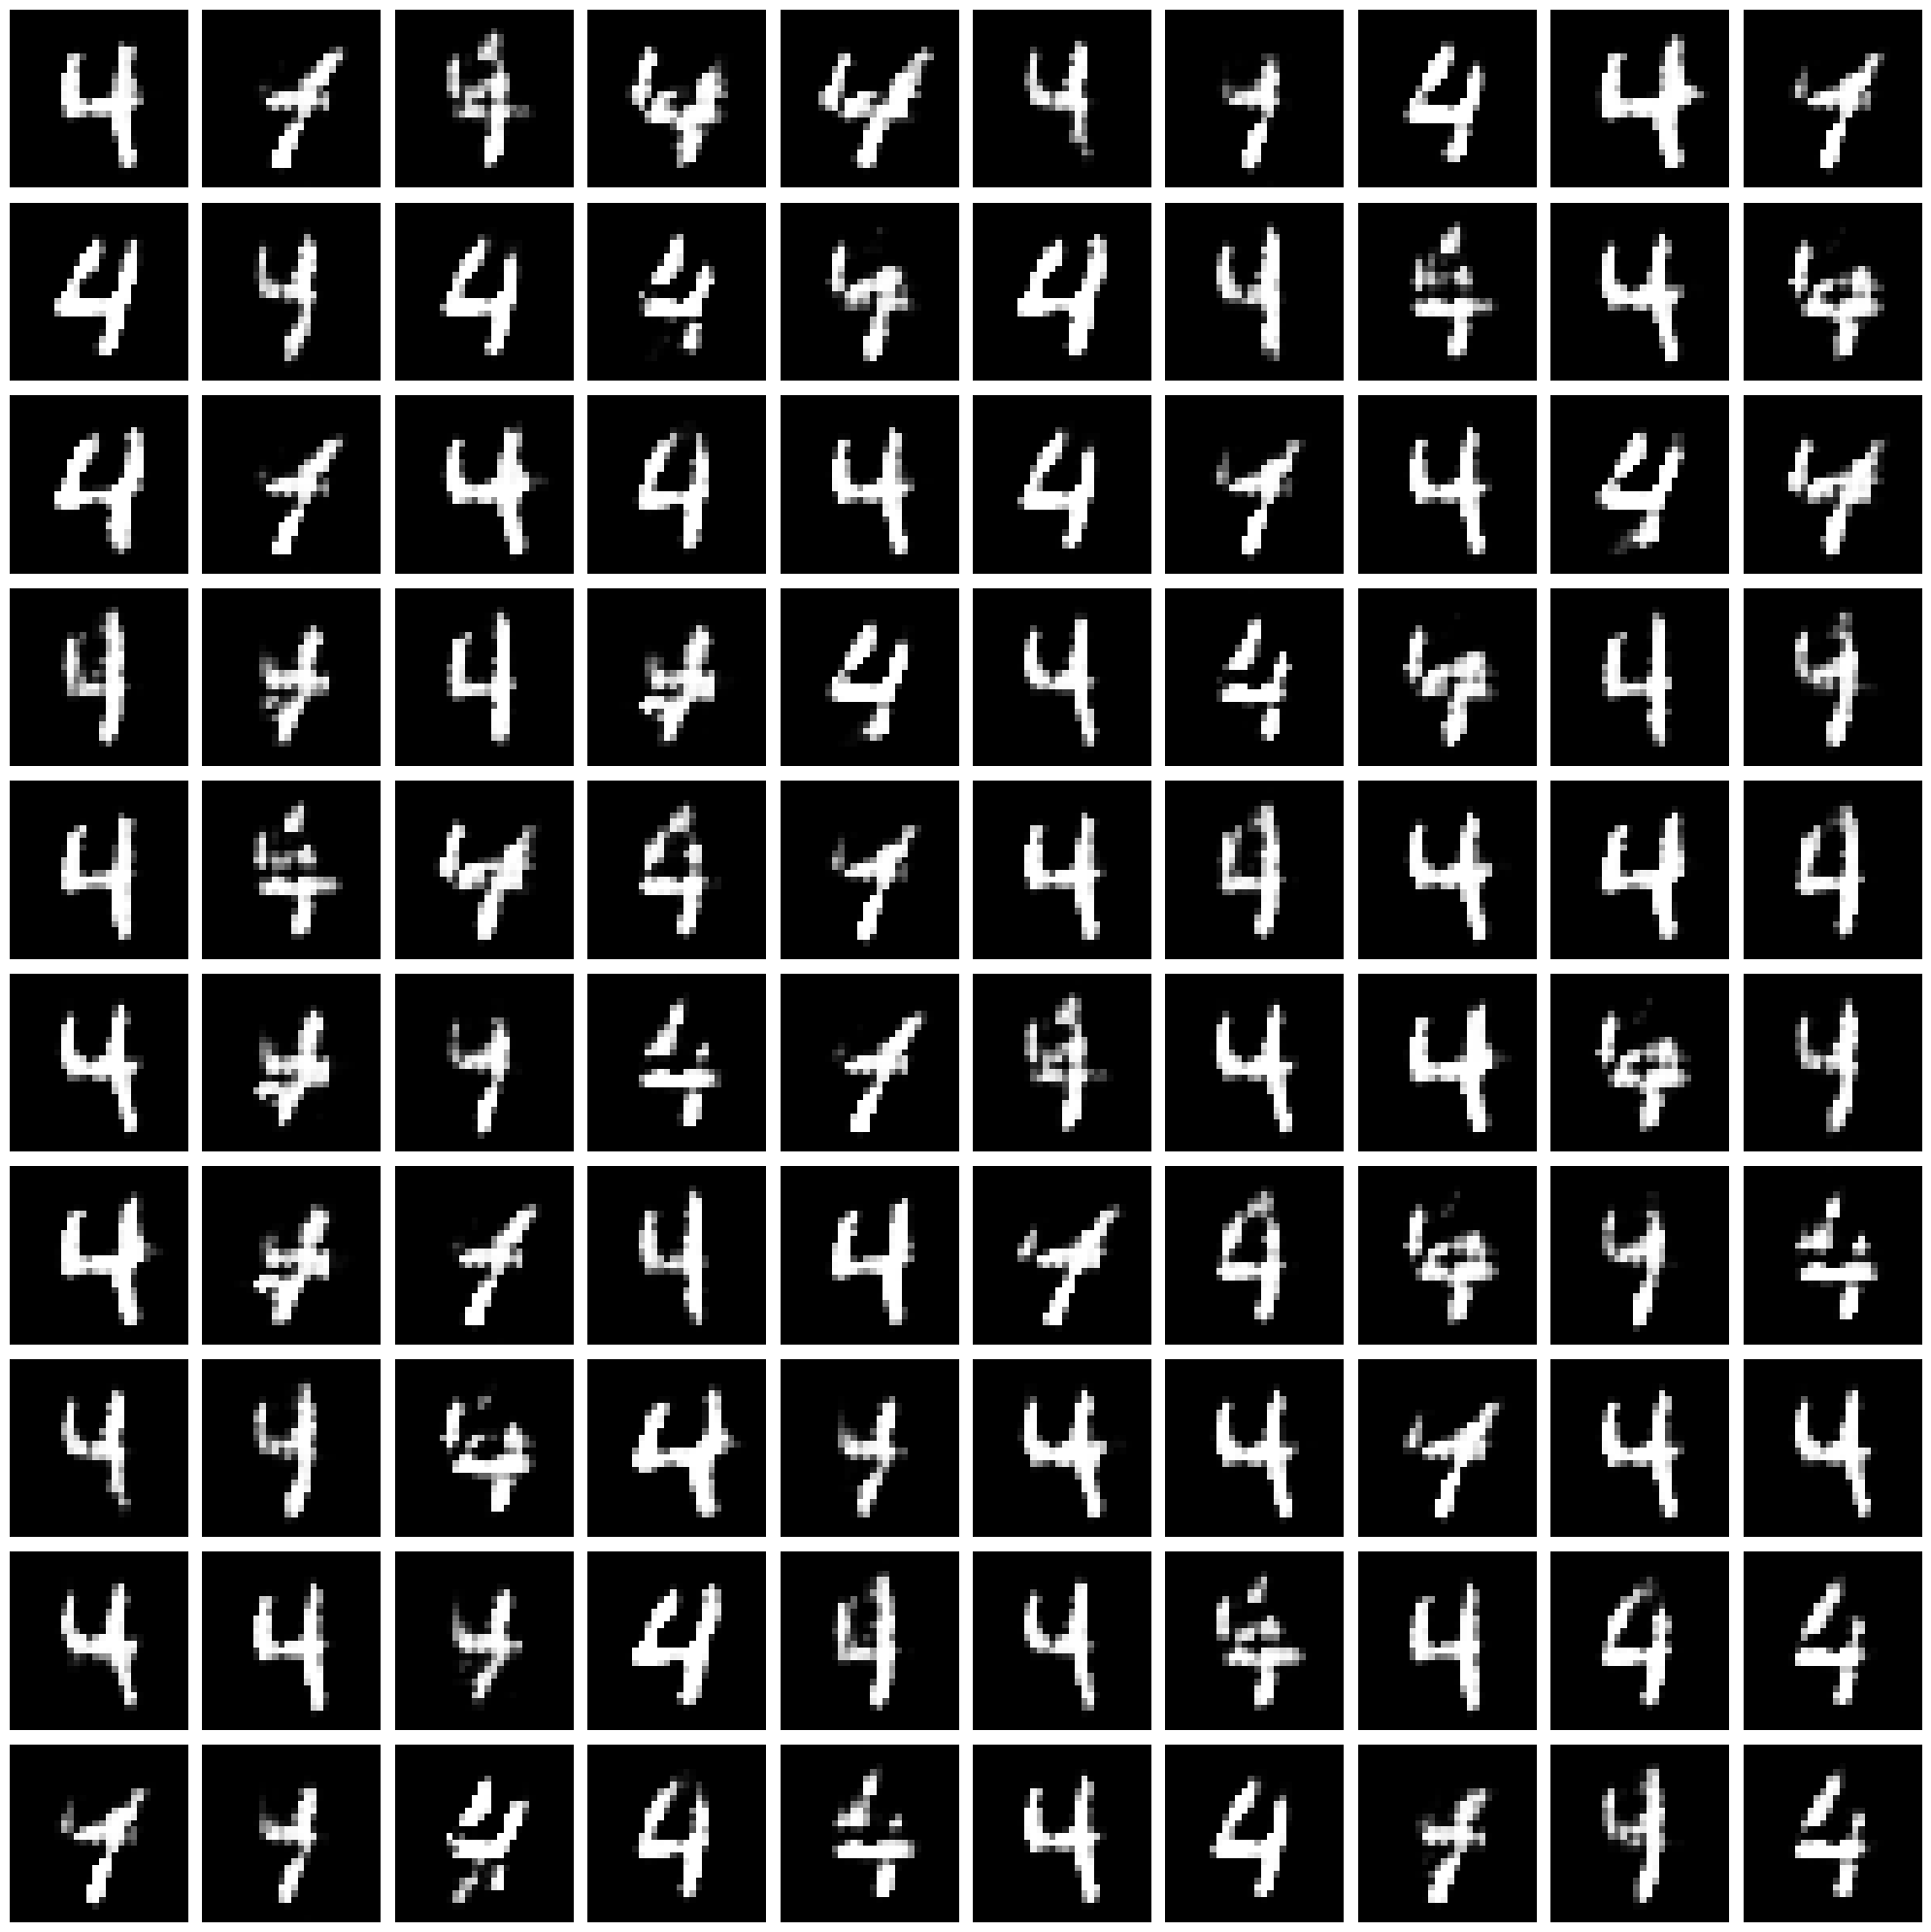

In [23]:
n = 10
plt.figure(figsize=(20, 20))

for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    x = np.random.uniform(-1, 1)
    y = np.random.uniform(-1, 1)
    img = generator.predict(np.expand_dims([x, y], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()



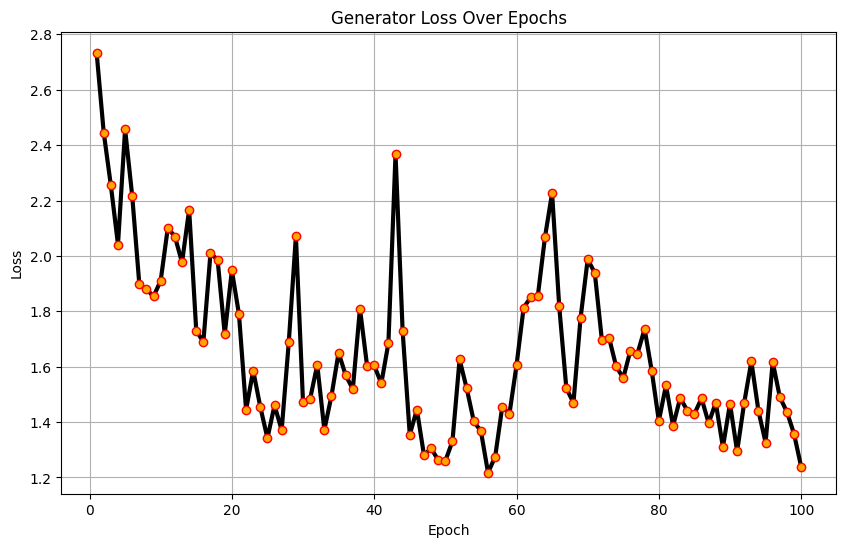

In [26]:
#plottingh loss
loss_values = [float(loss.numpy()) for loss in gen_history]

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), loss_values,color='black',
         linewidth=3,
         linestyle='-',
         marker='o',
         markerfacecolor='orange',
         markeredgecolor='red')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
